### Librerías utilizadas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Cargar el excel en formato .csv

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving paso_alsina.csv to paso_alsina.csv


### IWQI: Definiciones y funciones

In [ ]:
##### DWQI
df_col_dwqi = ["Muestra","K+", "Na+","Mg2+", "Ca2+","HCO3-","Cl-","SO42-","pH","SDT" ]

relative_weights_DWQI ={
    "K+": 0.065,
    "Na+": 0.129,
    "Mg2+": 0.097,
    "Ca2+": 0.097,
    "HCO3-": 0.032,
    "Cl-": 0.161,
    "SO42-": 0.161,
    "pH": 0.097,
    "SDT": 0.161
}

standards_WHO_DWQI ={
   # mg/L
    "K+": 12,
    "Na+": 200,
    "Mg2+": 30,
    "Ca2+": 75,
    "HCO3-": 120,
    "Cl-": 250,
    "SO42-": 250,
    "pH": 8.5,
    "SDT": 500
}
Ii_pH= 7

def Qi_DWQI(Mi,parameter):
  if parameter in standards_WHO_DWQI.keys():
    if parameter == 'pH':
      Qi_DWQI = (Mi-Ii_pH)/(standards_WHO_DWQI[parameter]-Ii_pH)
    else:
      Qi_DWQI = Mi/standards_WHO_DWQI[parameter]
    # Ii es 0 para todos menos para ph donde Ii=7
    #(Mi-Ii)/(Si-Ii)*100
  return Qi_DWQI*100


def calculoDWQI(xK, xNa, xMg, xCa, xHCO3, xCl, xSO42, xpH, xSDT):
  QiWi_DWQI=0
  sum_Wi=0

  Qi_vals = {
    "K+": Qi_DWQI(xK,'K+'),
    "Na+": Qi_DWQI(xNa,'Na+'),
    "Mg2+": Qi_DWQI(xMg,'Mg2+'),
    "Ca2+": Qi_DWQI(xCa,'Ca2+'),
    "HCO3-": Qi_DWQI(xHCO3,'HCO3-'),
    "Cl-": Qi_DWQI(xCl,'Cl-'),
    "SO42-": Qi_DWQI(xSO42,'SO42-'),
    "pH": Qi_DWQI(xpH,'pH'),
    "SDT": Qi_DWQI(xSDT,'SDT')
  }
  for k in Qi_vals.keys():
    QiWi_DWQI = QiWi_DWQI + Qi_vals[k]*relative_weights_DWQI[k]
    sum_Wi = sum_Wi + relative_weights_DWQI[k] # esto da 1

  DWQI = QiWi_DWQI/sum_Wi

  return DWQI

def CALCULO_DWQI(columna):
  xK = columna['K+']
  xMg = columna['Mg2+']
  xCa = columna['Ca2+']
  xSO42 = columna['SO42-']
  xpH = columna['pH']
  xNa = columna['Na+']
  xHCO3 = columna['HCO3-']
  xCl = columna['Cl-']
  xSDT = columna['SDT']
  return  calculoDWQI(xK, xNa, xMg, xCa, xHCO3, xCl, xSO42, xpH, xSDT)

##### Conversiones No convertir en este caso
def mg2meq(data_df, df_units):
    import pandas as pd

    factores_conversion = {
        "Na+": 1 / 23.0,      # Na+ peso equivalente = 23
        "Cl-": 1 / 35.45,     # Cl- peso equivalente ≈ 35.45
        "HCO3-": 1 / 61.0,    # HCO3- peso equivalente ≈ 61
        "Ca2+": 2 / 40.08,    # Ca2+ peso equivalente ≈ 20.04 (40.08/2)
        "Mg2+": 2 / 24.31     # Mg2+ peso equivalente ≈ 12.155
        }
    df_convertido = data_df.copy()
    for col in data_df.columns:
        if col in factores_conversion:
            if df_units[col].values == 'mg/L':
                df_convertido[col] = pd.to_numeric(data_df[col], errors="coerce") * factores_conversion[col]
    return df_convertido




### Funciones para leer el archivo

In [ ]:
def read_file(uploaded):
    # Leer según extensión
    if uploaded.endswith(".csv"):
        df=pd.read_csv(uploaded, encoding='cp1252')
    else:
        if uploaded.endswith(".xls"):
            df = pd.read_excel(uploaded,engine="xlrd")
        else:
            df=pd.read_excel(uploaded, engine="openpyxl")
    return df

def load_data(df):
    # Extraer la información acerca de las unidades de los parametros
    df_units=pd.DataFrame([df.iloc[0]], columns=df.columns)
    #df_units.columns = df.columns
    df.drop(df.index[0], inplace=True)
    df.reset_index(drop=True)

    # Datos de tipo númerico, excepto los nombres de la muestra
    for c in df.columns:
        if c != 'Muestra':
            df[c] = pd.to_numeric(df[c], errors='coerce')

    return df, df_units

def check_columns(df, df_cols):
    # Validar si estan las columnas requeridas, segun el indice a calcular
    missing_cols = [col for col in df_cols if col not in df.columns]
    return missing_cols

def check_data(df):
    # Validar si hay datos vacíos
    datos_faltantes = df.isnull().any()
    return datos_faltantes


def upload_data(uploaded):
    uploaded_ok = False
    if (uploaded is not None) :
        # Leer según extensión (se supone que el usuario lo sube correctamente)
        df_read = read_file(uploaded)
        df_read, df_units = load_data(df_read)

        # Chequear si hay columnas faltantes
        missing_columns =check_columns(df_read, df_col_dwqi)

        actual_columns = [col for col in df_col_dwqi if col not in missing_columns]

        # Chequear si hay datos faltantes en las columnas, que se requieren (pueden haber columnas faltantes)
        datos_faltantes = check_data(df_read[actual_columns])
        if missing_columns:
            print(f"⚠️ Faltan columnas obligatorias: {', '.join(missing_columns)}")
        if datos_faltantes.any():
            print(df_read)
            columnas_con_nulos = df_read[datos_faltantes.tolist()]
            print(f"⚠️ Hay datos faltantes en las columnas: {', '.join(columnas_con_nulos)}")
        if not (datos_faltantes.any() or missing_columns):
            df=df_read
            print("✅ Datos cargados correctamente.")
            #if "df" not in st.session_state:
            #    st.session_state.df = df
            uploaded_ok = True
    return df, uploaded_ok

### Calculo DWQI con el archivo .csv

In [ ]:
name= 'DWQI'
#qi_ranges = qi_ranges_DWQI
relative_weights = relative_weights_DWQI
df_cols = df_col_dwqi
df = pd.DataFrame(0,index=range(1),columns=df_cols + [name])
#intervals = dwqi_intervals
df['Muestra']='S/N'
cols_numericas = df.columns.difference(['Muestra'])
df[cols_numericas] = df[cols_numericas].astype(float)
calculate_index = CALCULO_DWQI

In [ ]:
df_read

NameError: name 'df_read' is not defined

In [ ]:
# Leer según extensión
df_read = read_file(list(uploaded.keys())[0])
df_read, df_units = load_data(df_read)

# Chequear si hay columnas faltantes
missing_columns =check_columns(df_read, df_col_dwqi)

actual_columns = [col for col in df_col_dwqi if col not in missing_columns]

# Chequear si hay datos faltantes en las columnas, que se requieren (pueden haber columnas faltantes)
datos_faltantes = check_data(df_read[actual_columns])
if missing_columns:
  print(f"⚠️ Faltan columnas obligatorias: {', '.join(missing_columns)}")
if datos_faltantes.any():
  print(df_read)
  columnas_con_nulos = df_read[datos_faltantes.tolist()]
  print(f"⚠️ Hay datos faltantes en las columnas: {', '.join(columnas_con_nulos)}")
if not (datos_faltantes.any() or missing_columns):
  df=df_read
  #df=mg2meq(df, df_units)
  DWQI_resultados = df.apply(calculate_index, axis=1)
  df['DWQI'] = DWQI_resultados
  print("✅ Indice calculado correctamente.")


✅ Indice calculado correctamente.


### Visualización rapida del IWQI calculado.

In [ ]:
#cambiar el tipo de columna a entero
df['Muestra'] = df['Muestra'].astype(int)

###

<Axes: xlabel='Muestra'>

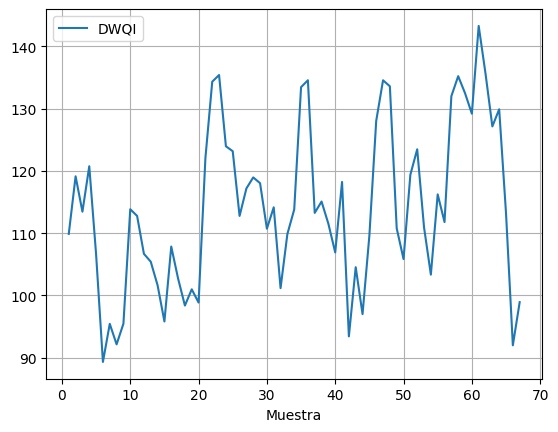

In [ ]:
df.plot(x='Muestra', y='DWQI', kind='line' ,grid=True)


### Guardar el dataframe df en formato .csv

-En la barra del costado izquierdo clickear en el icono de la carpeta.

-Buscar el archivo descargado (IWQI_nombreEstacion.csv).

-Hacer click derecho sobre ese archivo, y descargar.

In [ ]:
#guardar el dataframe df en formato .csv
df.to_csv(f'DWQI_{list(uploaded.keys())[0]}', index=False)
